<a href="https://colab.research.google.com/github/Ashique01/Spam-Email-Detection-using-nb-dt-nn-rt-algortihm/blob/main/finalSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Define the SpamDetector class
class SpamDetector:
    
    def __init__(self, classifier_type='nb'):
        self.vectorizer = TfidfVectorizer()
        if classifier_type == 'nb':
            self.classifier = MultinomialNB()
        elif classifier_type == 'dt':
            self.classifier = DecisionTreeClassifier(max_depth=3)
        elif classifier_type == 'nn':
            self.classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
        elif classifier_type == 'rf':
          self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.stopwords = stopwords.words('english')
        self.stemmer = PorterStemmer()
        
    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove punctuations and digits
        text = re.sub('[^a-z]+', ' ', text)
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Remove stopwords and stem the words
        words = [self.stemmer.stem(word) for word in tokens if word not in self.stopwords]
        # Join the words to form the processed text
        processed_text = ' '.join(words)
        return processed_text
    
    def preprocess_data(self, data):
        # Preprocess each text in the data and return as a list of preprocessed texts
        preprocessed_data = []
        for text in data:
            preprocessed_text = self.preprocess_text(text)
            preprocessed_data.append(preprocessed_text)
        return preprocessed_data
    
    def train(self, X_train, y_train):
        # Vectorize the preprocessed training data
        X_train_vectorized = self.vectorizer.fit_transform(X_train)
        # Train the classifier on the vectorized training data
        self.classifier.fit(X_train_vectorized, y_train)
        
    def predict(self, X_test):
        # Preprocess the testing data
        X_test_preprocessed = self.preprocess_data(X_test)
        # Vectorize the preprocessed testing data
        X_test_vectorized = self.vectorizer.transform(X_test_preprocessed)
        # Predict the labels for the testing data
        y_pred = self.classifier.predict(X_test_vectorized)
        return y_pred

In [5]:
# Load the dataset
data = pd.read_csv('spam.csv')
print(data)

     Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5572     spam                              Cheap pharmaceuticals
5573     spam                                   Enlarge your...!
5574     spam                                    Get rich quick!
5575     spam                  Your account has been compromised
5576     spam  Your account has been compromised!! To protect...

[5577 rows x 2 columns]


In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Message'], data['Category'], test_size=0.3, random_state=42)


## Naive Bayes Classifier

In [7]:
# Create the SpamDetector instance
detector = SpamDetector(classifier_type='nb')

# Preprocess the training data
X_train_processed = detector.preprocess_data(X_train)

# Train the classifier
detector.train(X_train_processed, y_train)

# Predict the labels for the testing data
y_pred = detector.predict(X_test)

# Evaluate the performance of the classifier
nb_accuracy = accuracy_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred, pos_label='spam')
nb_recall = recall_score(y_test, y_pred, pos_label='spam')
nb_f1 = f1_score(y_test, y_pred, pos_label='spam')
print("Naive Bayes Accuracy: {:.4f}".format( nb_accuracy))
print('Naive Bayes Precision:  {:.4f}'.format( nb_precision))
print('Naive Bayes Recall:  {:.2f}'.format( nb_recall))
print('Naive Bayes f1:  {:.2f}'.format( nb_f1))

Naive Bayes Accuracy: 0.9659
Naive Bayes Precision:  1.0000
Naive Bayes Recall:  0.75
Naive Bayes f1:  0.86


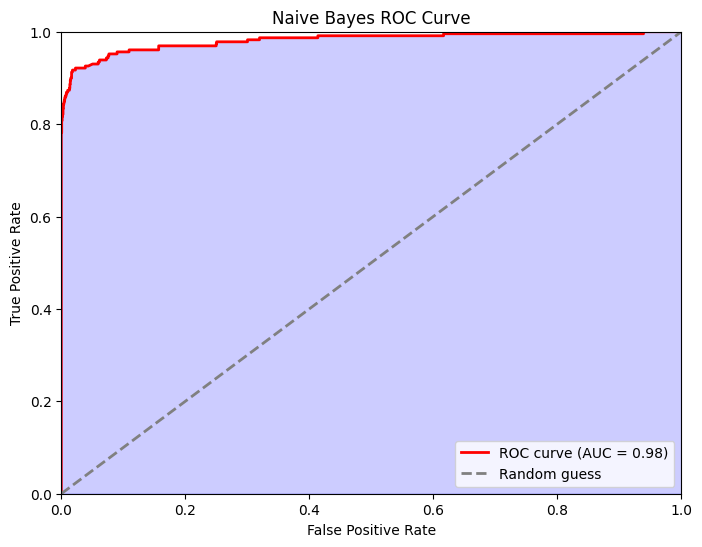

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
y_pred_proba = detector.classifier.predict_proba(detector.vectorizer.transform(detector.preprocess_data(X_test)))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
nb_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend(loc="lower right")

# Save the plot to a file
plt.savefig('nb_roc_curve.png')

# Display the plot
plt.show()


## Decision Tree

In [9]:
# Create the SpamDetector instance with decision tree classifier
detector = SpamDetector(classifier_type='dt')

# Preprocess the training data
X_train_processed = detector.preprocess_data(X_train)

# Train the classifier
detector.train(X_train_processed, y_train)

# Predict the labels for the testing data
y_pred = detector.predict(X_test)

# Evaluate the performance of the classifier
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred, pos_label='spam')
dt_recall = recall_score(y_test, y_pred, pos_label='spam')
dt_f1 = f1_score(y_test, y_pred, pos_label='spam')

print("Decision Tree Accuracy: {:.4f}".format( dt_accuracy))
print('Decision Tree Precision:  {:.4f}'.format(dt_precision))
print('Decision Tree Recall:  {:.4f}'.format(dt_recall))
print('Decision Tree f1:  {:.4f}'.format(dt_f1))

Decision Tree Accuracy: 0.9253
Decision Tree Precision:  0.7653
Decision Tree Recall:  0.6550
Decision Tree f1:  0.7059


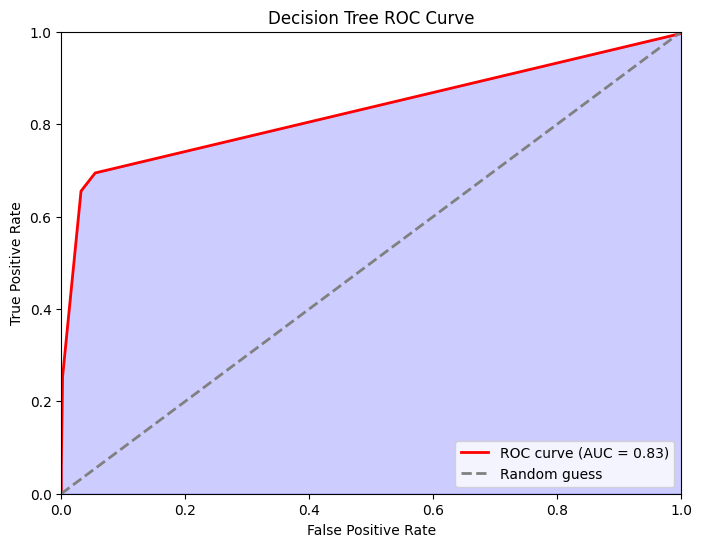

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
y_pred_proba = detector.classifier.predict_proba(detector.vectorizer.transform(detector.preprocess_data(X_test)))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
dt_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")

# Save the plot to a file
plt.savefig('dt_roc_curve.png')

# Display the plot
plt.show()


## Neural Network

In [11]:
# Create the SpamDetector instance with decision tree classifier
detector = SpamDetector(classifier_type='nn')

# Preprocess the training data
X_train_processed = detector.preprocess_data(X_train)

# Train the classifier
detector.train(X_train_processed, y_train)

# Predict the labels for the testing data
y_pred = detector.predict(X_test)

# Evaluate the performance of the classifier
nn_accuracy = accuracy_score(y_test, y_pred)
nn_precision = precision_score(y_test, y_pred, pos_label='spam')
nn_recall = recall_score(y_test, y_pred, pos_label='spam')
nn_f1 = f1_score(y_test, y_pred, pos_label='spam')

print("Neural Network Accuracy: {:.4f}".format(nn_accuracy))
print('Neural Network Precision:  {:.4f}'.format(nn_precision))
print('Neural Network Recall:  {:.4f}'.format(nn_recall))
print('Neural Network f1:  {:.4f}'.format(nn_f1))

Neural Network Accuracy: 0.9785
Neural Network Precision:  0.9617
Neural Network Recall:  0.8777
Neural Network f1:  0.9178


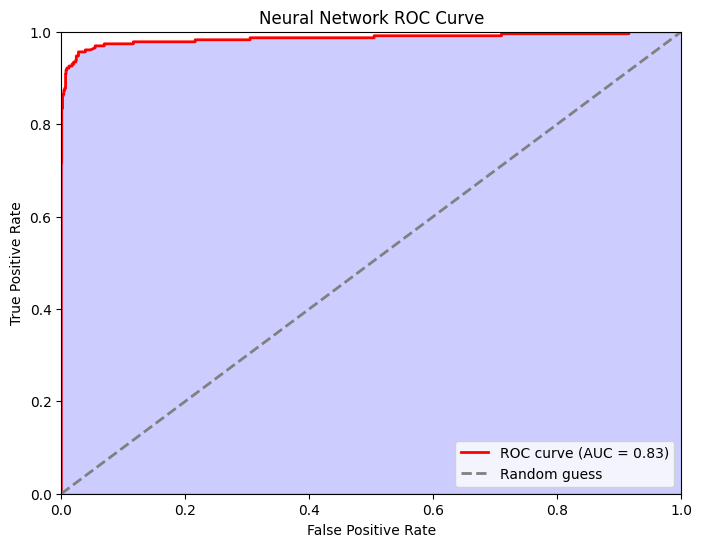

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
y_pred_proba = detector.classifier.predict_proba(detector.vectorizer.transform(detector.preprocess_data(X_test)))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
nn_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve')
plt.legend(loc="lower right")

# Save the plot to a file
plt.savefig('nn_roc_curve.png')

# Display the plot
plt.show()


## Random Forest

In [13]:
# Create the SpamDetector instance with decision tree classifier
detector = SpamDetector(classifier_type='rf')

# Preprocess the training data
X_train_processed = detector.preprocess_data(X_train)

# Train the classifier
detector.train(X_train_processed, y_train)

# Predict the labels for the testing data
y_pred = detector.predict(X_test)

# Evaluate the performance of the classifier
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, pos_label='spam')
rf_recall = recall_score(y_test, y_pred, pos_label='spam')
rf_f1 = f1_score(y_test, y_pred, pos_label='spam')

print("Random Forest Accuracy: {:.4f}".format(rf_accuracy))
print('Random Forest Precision:  {:.4f}'.format(rf_precision))
print('Random Forest Recall:  {:.4f}'.format(rf_recall))
print('Random Forest f1:  {:.4f}'.format(rf_f1))

Random Forest Accuracy: 0.9773
Random Forest Precision:  1.0000
Random Forest Recall:  0.8341
Random Forest f1:  0.9095


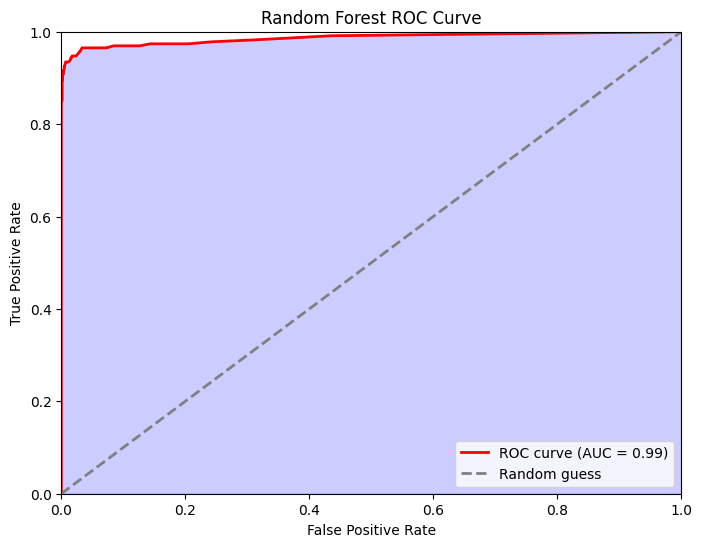

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
y_pred_proba = detector.classifier.predict_proba(detector.vectorizer.transform(detector.preprocess_data(X_test)))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
rf_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")

# Save the plot to a file
plt.savefig('rf_roc_curve.png')

# Display the plot
plt.show()


In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


df = pd.DataFrame({
    'Algorithm': ['Naive Bayes', 'Decision Tree', 'Neural Network', 'Random Forest'],
    'Accuracy': [nb_accuracy, dt_accuracy, nn_accuracy, rf_accuracy],
    'Precision': [nb_precision, dt_precision, nn_precision, rf_precision],
    'Recall': [nb_recall, dt_recall, nn_recall, rf_recall],
    'F1-Score': [nb_f1, dt_f1, nn_f1, rf_f1],
    'AUC': [nb_roc_auc, dt_roc_auc, nn_roc_auc, rf_roc_auc]
 
})


df.to_csv('model_evaluation.csv', index='Algorithm')

In [16]:
df.head()

,Algorithm,Accuracy,Precision,Recall,F1-Score,AUC
0,Naive Bayes,0.965950,1.000000,0.751092,0.857855,0.981300
1,Decision Tree,0.925329,0.765306,0.655022,0.705882,0.828343
2,Neural Network,0.978495,0.961722,0.877729,0.917808,0.985688
3,Random Forest,0.977300,1.000000,0.834061,0.909524,0.986412


In [17]:

# Define the list of classifiers
classifiers = [
    ('Naive Bayes', 'nb'),
    ('Decision Tree', 'dt'),
    ('Neural Network', 'nn'),
    ('Random Forest', 'rf')
]

In [18]:
# Initialize a dictionary to store cross-validation results
cv_results = {'Algorithm': [], 'Cross-Validation': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}

for classifier_name, classifier_type in classifiers:
    # Create the SpamDetector instance
    detector = SpamDetector(classifier_type=classifier_type)

    # Preprocess the data
    X_processed = detector.preprocess_data(data['Message'])

    # Perform 5-fold cross-validation
    X_vectorized = detector.vectorizer.fit_transform(X_processed)
    cv_scores = cross_val_score(detector.classifier, X_vectorized, data['Category'], cv=5, scoring='accuracy')
    cv_accuracy = cv_scores.mean()

    # Perform classification report for precision, recall, and F1-score
    detector.classifier.fit(X_vectorized, data['Category'])
    classification_report_dict = classification_report(data['Category'], detector.classifier.predict(X_vectorized), output_dict=True)

    # Update the cross-validation results dictionary
    cv_results['Algorithm'].append(classifier_name)
    cv_results['Cross-Validation'].append('5-Fold')
    cv_results['Accuracy'].append(cv_accuracy)
    cv_results['Precision'].append(classification_report_dict['weighted avg']['precision'])
    cv_results['Recall'].append(classification_report_dict['weighted avg']['recall'])
    cv_results['F1-score'].append(classification_report_dict['weighted avg']['f1-score'])

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(detector.classifier, X_vectorized, data['Category'], cv=10, scoring='accuracy')
    cv_accuracy = cv_scores.mean()

    # Perform classification report for precision, recall, and F1-score
    detector.classifier.fit(X_vectorized, data['Category'])
    classification_report_dict = classification_report(data['Category'], detector.classifier.predict(X_vectorized), output_dict=True)

    # Update the cross-validation results dictionary
    cv_results['Algorithm'].append(classifier_name)
    cv_results['Cross-Validation'].append('10-Fold')
    cv_results['Accuracy'].append(cv_accuracy)
    cv_results['Precision'].append(classification_report_dict['weighted avg']['precision'])
    cv_results['Recall'].append(classification_report_dict['weighted avg']['recall'])
    cv_results['F1-score'].append(classification_report_dict['weighted avg']['f1-score'])

df = pd.DataFrame(cv_results)
df.to_csv('cross_validation_results.csv', index=False)




In [19]:
df.head(10)

,Algorithm,Cross-Validation,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,5-Fold,0.965931,0.979860,0.979380,0.978647
1,Naive Bayes,10-Fold,0.968980,0.979860,0.979380,0.978647
2,Decision Tree,5-Fold,0.931683,0.936554,0.939394,0.936012
3,Decision Tree,10-Fold,0.933476,0.936554,0.939394,0.936012
4,Neural Network,5-Fold,0.979917,0.999821,0.999821,0.999821
5,Neural Network,10-Fold,0.982785,0.999821,0.999821,0.999821
6,Random Forest,5-Fold,0.976151,1.000000,1.000000,1.000000
7,Random Forest,10-Fold,0.977763,1.000000,1.000000,1.000000


In [20]:
# Initialize a dictionary to store cross-validation results
cv_results = {'Algorithm': [], 'Cross-Validation': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}

# Assuming data_subset = data.sample(frac=0.1, random_state=42) to select 10% of the data
data_subset = data.sample(frac=0.1, random_state=42)

for classifier_name, classifier_type in classifiers:
    # Create the SpamDetector instance
    detector = SpamDetector(classifier_type=classifier_type)

    # Preprocess the data
    X_processed = detector.preprocess_data(data_subset['Message'])

    # Perform Jackknife resampling
    X_vectorized = detector.vectorizer.fit_transform(X_processed)
    cv = LeaveOneOut()
    cv_scores = cross_val_score(detector.classifier, X_vectorized, data_subset['Category'], cv=cv, scoring='accuracy')
    cv_accuracy = cv_scores.mean()

    # Perform classification report for precision, recall, and F1-score
    detector.classifier.fit(X_vectorized, data_subset['Category'])
    classification_report_dict = classification_report(data_subset['Category'], detector.classifier.predict(X_vectorized), output_dict=True)

    # Update the cross-validation results dictionary
    cv_results['Algorithm'].append(classifier_name)
    cv_results['Cross-Validation'].append('Jackknife')
    cv_results['Accuracy'].append(cv_accuracy)
    cv_results['Precision'].append(classification_report_dict['weighted avg']['precision'])
    cv_results['Recall'].append(classification_report_dict['weighted avg']['recall'])
    cv_results['F1-score'].append(classification_report_dict['weighted avg']['f1-score'])

df = pd.DataFrame(cv_results)
df.to_csv('cross_validation_results_jackKnife.csv', index=False)

# Print the cross-validation results
print(df)


        Algorithm Cross-Validation  Accuracy  Precision    Recall  F1-score
0     Naive Bayes        Jackknife  0.912186   0.959050  0.956989  0.953777
1   Decision Tree        Jackknife  0.912186   0.941444  0.942652  0.938793
2  Neural Network        Jackknife  0.960573   1.000000  1.000000  1.000000
3   Random Forest        Jackknife  0.942652   1.000000  1.000000  1.000000
